In [1]:
from IPython.display import Markdown, display
import sys
import copy
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import stdev as sd, mean
from scipy.stats import randint as sp_randint, uniform
import random
import time

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas,\
                    load_preproc_data_adult_5att, load_preproc_data_artificial, \
                    load_preproc_data_adult_continuous, load_preproc_data_german_continuous
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from common_utils import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn import svm, datasets
from sklearn.datasets import load_digits, load_iris, make_hastie_10_2
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

sys.path.append('/home/andrew/python-virtual-environments/hyperband/scikit-hyperband/hyperband')
from miti_search import HyperbandSearchCV

import pickle
filename = 'X_y_weight'
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()
filename = 'X_y_data_info_adult_step_10'
infile = open(filename,'rb')
transf_data_info = pickle.load(infile)
infile.close()


In [2]:
X_check = transf_data_info['X']
y_check = transf_data_info['y']
w_check = transf_data_info['og_w']
og_pred = transf_data_info['y_pred']
bin_pred = transf_data_info['y_bin_pred']
thresh = transf_data_info['thresh']
test_ind = transf_data_info['test_ind']
sample_dict = transf_data_info['sample_dict']
step = transf_data_info['step']
unique_w_indexes = np.unique(w_check['sample_weight'], return_index=True)
unique_w_indexes

(array([0.79063385, 0.85692239, 1.09011938, 2.14975936]), array([3, 2, 0, 6]))

In [3]:
lmod = LogisticRegression()
lmod.fit(X_check[7327:,], y_check[7327:], w_check['sample_weight'][7327:])
y_train_pred = lmod.predict(X_check[7327:,])
y_test_pred = lmod.predict_proba(X_check[:7327])[:,1].reshape(-1,1)

transformed_binary_data = [int(i[0]) for i in bin_pred] # orig values form RWfor comparison (only is tester is included in dict) 
y_binary = [1 if i > thresh else 0 for i in y_test_pred]

print(np.array_equal(y_test_pred, og_pred))
print(np.array_equal(y_binary, transformed_binary_data), '... Only equal if you have placed the tester data in the dict')
print('accu: ', accuracy_score(y_binary, y_check[:7327]))
print('bal acc: ', balanced_accuracy_score(y_binary, y_check[:7327]))

priv, unpriv, p_pos, u_pos, p_tp, u_tp, pred_p_pos, pred_u_pos = 0,0,0,0,0,0,0,0

for i in range(len(X_check[:7327][:,1])):
    if X_check[:7327][:,1][i] > 0:
        priv +=1
        if y_check[:7327][i] == 1:
            p_pos +=1
            if y_binary[i] == 1:
                p_tp +=1
        if y_binary[i] == 1:
            pred_p_pos +=1
    else:
        unpriv +=1
        if y_check[:7327][i] == 1:
            u_pos +=1
            if y_binary[i] == 1:
                u_tp +=1
        if y_binary[i] == 1:
            pred_u_pos +=1
    
total = len(y_binary)
print(total)
print(priv, unpriv, p_pos, u_pos, p_tp, u_tp)
print('percent priv:', priv/total)
print('percent posi:', (p_pos+u_pos)/total)
print('percent pred:', (pred_p_pos+pred_u_pos)/total)
print("TPR", p_tp/p_pos, u_tp/u_pos, (p_tp+u_tp)/(p_pos+u_pos))
print('TP-Ratio:', (u_tp/u_pos)/(p_tp/p_pos))
print('disp_imp:', (pred_u_pos/unpriv)/(pred_p_pos/priv))

pos, neg, tps, tns = 0,0,0,0

for i in range(len(y_binary)):
    if y_check[:7327][i] == 1:
        pos += 1
        if y_binary[i] == 1:
            tps +=1
    else:
        neg += 1
        if y_binary[i] == 0:
            tns +=1

print(pos, neg, tps, tns)
trrs = tps/pos
tnrs = tns/neg

bal_acc = 0.5*(trrs+tnrs)
print('bal_acc:', bal_acc)

True
False ... Only equal if you have placed the tester data in the dict
accu:  0.7621127337245803
bal acc:  0.688503435569757
7327
4943 2384 1508 272 926 175
percent priv: 0.6746280878940903
percent posi: 0.24293708202538555
percent pred: 0.29548246212638185
TPR 0.6140583554376657 0.6433823529411765 0.6185393258426967
TP-Ratio: 1.0477544149409226
disp_imp: 0.7785152285887279
1780 5547 1101 4483
bal_acc: 0.7133619650666521


In [8]:
total_time = []
for i in range(1):
    start_time = time.time()
    index_map = transf_data_info['index_map']
    uniform_weights = {'priv_pos': sp_randint(int(index_map['pp']*100//1), 100),
                       'priv_neg': sp_randint(100, int(index_map['pn']*100//1)),
                       'unpriv_pos': sp_randint(100, int(index_map['up']*100//1)),
                       'unpriv_neg': sp_randint(int(index_map['un']*100//1), 100)}

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 1 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=1
    ne=0
    att=1

    is_distribution = True

    if is_distribution:
        sample_dict = uniform_weights

    # print('sample_dict: ',sample_dict)

    search = HyperbandSearchCV(model, param_dist, 
                               resource_param='max_iter',
                               scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=sample_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po, ne, att)
    this_time = (time.time() - start_time)
    total_time.append(this_time)
    print(this_time)
# print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

61.528448820114136


In [9]:
indexes=[0,2,3,6]
working_dict = search.data_list.copy()
hyper_band_bracket = working_dict[-1]
# working_dict[-1].pop('hyperband_bracket')

for i in working_dict:
    for j in range(len(i['param_sample_weight'])):
        unique_weights = []
        for k in indexes:
            unique_weights.append(i['param_sample_weight'][j][k])
        i['param_sample_weight'][j] = unique_weights
    i.pop('params') 
df = pd.DataFrame()
for dict_array in search.data_list:
    df = pd.concat([df, pd.DataFrame.from_dict(dict_array)], sort=False)
print(df.columns)
df

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'mean_test_acc', 'std_test_acc', 'mean_test_ba', 'std_test_ba',
       'mean_test_pp', 'std_test_pp', 'mean_test_di', 'std_test_di',
       'mean_test_tpr', 'std_test_tpr', 'mean_test_tnr', 'std_test_tnr',
       'mean_test_posrat', 'std_test_posrat', 'mean_test_tradeoff_met',
       'std_test_tradeoff_met', 'param_sample_weight', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'hyperband_bracket'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_acc,std_test_acc,mean_test_ba,std_test_ba,mean_test_pp,std_test_pp,...,param_sample_weight,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,hyperband_bracket
0,0.067480,0.030695,0.020757,0.003595,0.608873,0.012315,0.722488,0.011526,0.585702,0.012970,...,"[1, 1, 1, 1]",0.725828,0.710735,0.710082,0.741391,0.724402,0.722488,0.011525,81,NaN
1,0.012700,0.002002,0.021651,0.006053,0.608343,0.010034,0.937560,0.011150,0.562482,0.012476,...,"[1.090119384675988, 0.8569223871853865, 0.7906...",0.938721,0.939823,0.941938,0.950475,0.916844,0.937560,0.011150,1,NaN
2,0.011447,0.001904,0.016347,0.001434,0.613812,0.021145,0.808712,0.030728,0.565781,0.034175,...,"[1.02, 0.87, 0.81, 1.17]",0.793233,0.789293,0.835354,0.853830,0.771851,0.808712,0.030727,29,NaN
3,0.010974,0.002946,0.015202,0.000517,0.599480,0.008220,0.792917,0.009146,0.590809,0.008188,...,"[1.01, 0.97, 0.8, 1.95]",0.796829,0.789293,0.800701,0.801060,0.776702,0.792917,0.009146,40,NaN
4,0.009417,0.000040,0.015152,0.000500,0.610319,0.022376,0.811037,0.032916,0.570671,0.036837,...,"[1.06, 0.86, 0.91, 1.11]",0.800492,0.778458,0.844013,0.855519,0.776702,0.811037,0.032916,28,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.043375,0.000934,0.019394,0.007702,0.730730,0.004338,0.752768,0.005895,0.393607,0.007129,...,"[1.0, 0.87, 0.96, 1.46]",0.747279,0.753580,0.751225,0.763664,0.748092,0.752768,0.005895,170,5.0
183,0.051792,0.002366,0.019735,0.005366,0.742316,0.009945,0.791560,0.010059,0.355044,0.019339,...,"[1.05, 0.91, 0.96, 1.92]",0.788579,0.789030,0.802431,0.802261,0.775500,0.791560,0.010059,80,5.0
184,0.052732,0.007925,0.018698,0.004691,0.758166,0.004468,0.774977,0.005434,0.323827,0.007165,...,"[1.03, 0.91, 0.86, 1.62]",0.770633,0.775334,0.780766,0.780913,0.767239,0.774977,0.005434,130,5.0
185,0.049096,0.008391,0.019144,0.004505,0.747567,0.005228,0.805202,0.006291,0.339725,0.007863,...,"[1.06, 0.91, 0.9, 2.11]",0.799164,0.808799,0.809904,0.811940,0.796205,0.805202,0.006291,51,5.0


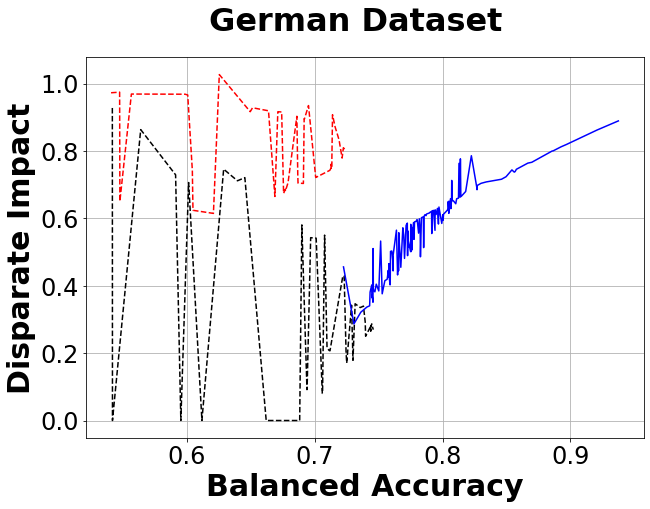

In [10]:
Data_Name = 'Adult_Random'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'mean_test_di'
df_sorted = df.sort_values(by=x_axis)
# df_lim_pp = df[df['mean_test_pp'] < 0.35].sort_values(by=x_axis)
# df_lim_tp = df[df['mean_test_tpr'] > 0.65].sort_values(by=x_axis)
# df_lim_tp_and_pp = df_lim_pp[df_lim_pp['mean_test_tpr'] > 0.65].sort_values(by=x_axis)

orig_array = transf_data_info['orig_array']
trans_array = transf_data_info['trans_array']
orig_sort = orig_array[orig_array[:,2].argsort()]
trans_sort = trans_array[trans_array[:,2].argsort()]

mx = df_sorted

# orig_sort = transf_data_info['orig_array'][transf_data_info['orig_array'][:,2].argsort()]
# trans_sort = transf_data_info['trans_array'][transf_data_info['trans_array'][:,2].argsort()]

fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('German Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_axis, fontsize=30, fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)

# ax1.plot(orig_sort[:,3], orig_sort[:,5], color='k', label='Original Data')
# ax1.plot(trans_sort[:,3], trans_sort[:,5], color='r', label='Re-weight Data')
# ax1.plot(orig_sort[:,3], orig_sort[:,8], '--', color='k', label='Original Data')
# ax1.plot(trans_sort[:,3], trans_sort[:,8], '--', color='r', label='Re-weight Data')
ax1.plot(orig_sort[:,2], orig_sort[:,4], '--', color='k', label='Original Data')
ax1.plot(trans_sort[:,2], trans_sort[:,4], '--', color='r', label='Re-weight Data')
# ax1.plot(mx[x_axis], mx['mean_test_acc'], color='k', label='Accuracy')
# ax1.plot(mx[x_axis], mx['mean_test_ba'], '--', color='k', label='Bal. Accuracy')
# ax1.plot(mx[x_axis], mx['mean_test_pp'], color='b', label='Percent Pos.')
ax1.plot(mx[x_axis], mx['mean_test_di'], color='b', label='Disparate Imp.')
# ax1.plot(mx[x_axis], mx['mean_test_tpr'], color='b', label='TPR')
# ax1.plot(mx[x_axis], mx['mean_test_posrat'], '--', color='b', label='TPR-ratio')
# ax1.plot(mx[x_axis], mx['mean_test_tradeoff_met'], color='y', label='Tradeoff Metric')
# ax1.plot(mx[x_axis], mx['mean_test_tnr'], color='r', label='TNR')

# start, end = ax1.get_ylim()
# ax1.yaxis.set_ticks(np.arange(start, end, 0.05))

# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_axis}_{y_axis}_og_miti_HO_{ratio}_{now}.png'
destination = file_loc + file_name
# plt.savefig(destination)

df.to_csv(f'/home/andrew/Desktop/Test_Files/HyperParamTune/HB_Mitigation_Outputs/German_output:tradeoff={ratio}_step{step}_thresh_{thresh}.csv', index=False)
df_sorted.to_csv(f'/home/andrew/Desktop/Test_Files/HyperParamTune/HB_Mitigation_Outputs/German_out_sorted:trade_off={ratio}_step{step}_thresh_{thresh}.csv', index=False)

In [11]:
#Example of HyperBand with Rand-Forest on Digits dataset
total_time = []
for i in range(1):
    start_time = time.time()

    index_map = transf_data_info['index_map']
    uniform_weights = {'priv_pos': sp_randint(int(index_map['pp']*100//1), 100),
                       'priv_neg': sp_randint(100, int(index_map['pn']*100//1)),
                       'unpriv_pos': sp_randint(100, int(index_map['up']*100//1)),
                       'unpriv_neg': sp_randint(int(index_map['un']*100//1), 100)}

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 0.5 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=1
    ne=0
    att=1
    
    is_distribution = True
    if is_distribution:
        sample_dict = uniform_weights

    r_search = RandomizedSearchCV(model, param_dist, n_iter=121,
                               scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=sample_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    r_search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po, ne, att)
    this_time = (time.time() - start_time)
    total_time.append(this_time)
    print(this_time)
# print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

35.192169189453125


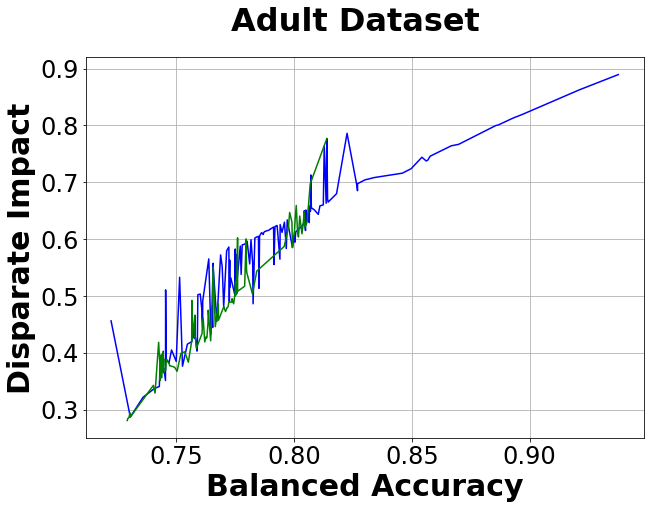

In [12]:
Data_Name = 'Adult_Rand'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'mean_test_di'

df_rand = pd.DataFrame()
for dict_array in r_search.data_list:
    df_rand = pd.concat([df_rand, pd.DataFrame.from_dict(dict_array)], sort=False)
rand_mx = df_rand.sort_values(by=x_axis)

fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('Adult Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_axis, fontsize=30, fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)


# ax1.plot(orig_sort[:,2], orig_sort[:,4], '--', color='k', label='Original Data')
# ax1.plot(trans_sort[:,2], trans_sort[:,4], '--', color='r', label='Re-weight Data')
# ax1.plot(mx[x_axis], mx['mean_test_acc'], color='k', label='Accuracy')
# ax1.plot(mx[x_axis], mx['mean_test_ba'], '--', color='k', label='Bal. Accuracy')
# ax1.plot(mx[x_axis], mx['mean_test_pp'], color='b', label='Percent Pos.')
ax1.plot(mx[x_axis], mx['mean_test_di'], color='b', label='Disparate Imp.')
# ax1.plot(grid_mx[x_axis], grid_mx['mean_test_di'], color='r', label='Disparate Imp.')
ax1.plot(rand_mx[x_axis], rand_mx['mean_test_di'], color='g', label='Disparate Imp.')


# ax1.plot(mx[x_axis], mx['mean_test_tpr'], color='b', label='TPR')
# ax1.plot(mx[x_axis], mx['mean_test_posrat'], '--', color='b', label='TPR-ratio')
# ax1.plot(mx[x_axis], mx['mean_test_tradeoff_met'], color='y', label='Tradeoff Metric')
# ax1.plot(mx[x_axis], mx['mean_test_tnr'], color='r', label='TNR')

now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_axis}_{y_axis}_og_miti_HO_{ratio}_{now}.png'
destination = file_loc + file_name
# plt.savefig(destination)

# df.to_csv(f'/home/andrew/Desktop/Test_Files/HyperParamTune/HB_Mitigation_Outputs/German_output:tradeoff={ratio}_step{step}_thresh_{thresh}.csv', index=False)
# df_sorted.to_csv(f'/home/andrew/Desktop/Test_Files/HyperParamTune/HB_Mitigation_Outputs/German_out_sorted:trade_off={ratio}_step{step}_thresh_{thresh}.csv', index=False)

In [13]:
import pickle
filename = 'Grid_adult_step_10'
infile = open(filename,'rb')
grid_data_info = pickle.load(infile)
infile.close()

grid_dict = grid_data_info['sample_dict']
grid_dict

{'pp': [0.79, 0.89, 0.99, 1.09],
 'pn': [1.0, 1.1],
 'up': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2],
 'un': [0.76, 0.86, 0.96, 1.06]}

In [15]:
#Run Hyperband
total_time = []
for i in range(10):
    start_time = time.time()

    index_map = transf_data_info['index_map']
    uniform_weights = {'priv_pos': sp_randint(int(index_map['pp']*100//1), 100),
                       'priv_neg': sp_randint(100, int(index_map['pn']*100//1)),
                       'unpriv_pos': sp_randint(100, int(index_map['up']*100//1)),
                       'unpriv_neg': sp_randint(int(index_map['un']*100//1), 100)}

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 0.5 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=1
    ne=0
    att=1

    is_distribution = True

    g_search = GridSearchCV(model, param_dist, scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=grid_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    g_search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po, ne, att)
    this_time = (time.time() - start_time)
    total_time.append(this_time)
    print(this_time)
print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

Num - configs before:  416
30
110.14877223968506
Num - configs before:  416
30
108.94246244430542
Num - configs before:  416
30
110.84965109825134
Num - configs before:  416
30
118.61781764030457
Num - configs before:  416
30
123.8235239982605
Num - configs before:  416
30
115.17742800712585
Num - configs before:  416
30
108.73314166069031
Num - configs before:  416
30
106.14339447021484
Num - configs before:  416
30
106.71727919578552
Num - configs before:  416
30
108.47796511650085
--- 111.76314358711242 seconds stdev: 5.700966901151912---


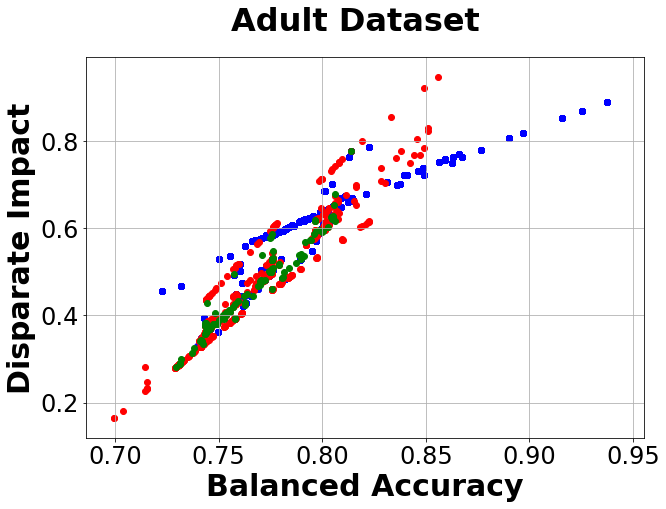

In [21]:
Data_Name = 'Adult_Rand_Grid_All'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'mean_test_di'

df_grid = pd.DataFrame()
for dict_array in g_search.data_list:
    df_grid = pd.concat([df_grid, pd.DataFrame.from_dict(dict_array)], sort=False)
grid_mx = df_grid.sort_values(by=x_axis)

fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('Adult Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)

ax1.scatter(mx[x_axis], mx['mean_test_di'], color='b', label='Disparate Imp.')
ax1.scatter(grid_mx[x_axis], grid_mx['mean_test_di'], color='r', label='Disparate Imp.')
ax1.scatter(rand_mx[x_axis], rand_mx['mean_test_di'], color='g', label='Disparate Imp.')


now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_axis}_{y_axis}_og_miti_HO_{ratio}.png'
destination = file_loc + file_name
plt.savefig(destination)

In [ ]:
mat